In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'
#os.environ['XLA_FLAGS']='--xla_gpu_autotune_level=2'

from timeit import default_timer as timer

import numpy as np
import jax
jax.config.update("jax_enable_x64", True)



import jax.numpy as jnp
from jax import jit
import jax_cosmo as jc      # Jax-cosmo lib
import jax.numpy as jnp
import jemupk_experimental  as emu      # Jax Emulator of CLASS

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
import matplotlib.patches as mpatches
mpl.rcParams['font.size'] = 20

In [3]:
import settings_gfpkq_120x20  as st         # configuration file (update 2/June/22)

In [4]:
print(f"(k,z)-grid: {st.nk}x{st.nz}")

(k,z)-grid: 120x20


In [5]:
root_dir = "./"
if st.sigma8:
    print("Using: Omega_cdm, Omega_b, sigma8, ns, h")
    tag='_Omega_sig8_'  + str(st.nk) + "x" + str(st.nz)  
else:
    raise NotImplementedError("No more in use")

load_dir = root_dir + '/pknl_components' + st.d_one_plus+tag

Using: Omega_cdm, Omega_b, sigma8, ns, h


In [6]:
# report the default number of worker threads on your system
from concurrent.futures import ThreadPoolExecutor
# create a thread pool with the default number of worker threads
executor = ThreadPoolExecutor()
# report the number of worker threads chosen by default
print(executor._max_workers)

20


In [7]:
#trigger the load
start=timer()
gp_factory = emu.GP_factory.make(load_dir)
end=timer()
print("load ok after: ",end-start, " sec.")

load ok after:  22.174271477386355  sec.


In [8]:
cosmo_jax = jc.Planck15()

In [9]:
start = timer()
Nk=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.k_max_h_by_Mpc, Nk, endpoint=True) #h/Mpc
z_star = jnp.array([0.,1., 2., 3.])
pk_linear_interp = emu.linear_pk(cosmo_jax, k_star,z_star)
end = timer()
print("end-start (sec)",end - start)

2022-07-04 10:46:08.680138: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[16,4800]{1,0} custom-call(f64[16,16]{1,0} %multiply.16, f64[16,4800]{1,0} %concatenate.744), custom_call_target="__cublas$gemm", metadata={op_type="dot_general" op_name="jit(jec_interp2d_v2)/dot_general[\n  dimension_numbers=(((1,), (0,)), ((), ()))\n  precision=None\n  preferred_element_type=None\n]" source_file="/sps/lsst/users/campagne/Jemu/util.py" source_line=82}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"256\",\"rhs_stride\":\"76800\"}" failed. Falling back to default algorithm. 


end-start (sec) 408.6834763903171


In [10]:
start = timer()
pk_nonlin_interp = emu.nonlinear_pk(cosmo_jax,k_star, z_star)
end = timer()
print("end-start (sec)",end - start)

end-start (sec) 7.121502384543419


In [11]:
%timeit pk_linear_interp=emu.linear_pk(cosmo_jax, k_star,z_star).block_until_ready()

22.1 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit  pk_nonlin_interp = emu.nonlinear_pk(cosmo_jax,k_star, z_star).block_until_ready()  # measure JAX compilation time

1.93 s ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
#%timeit emu.nonlinear_pk(cosmo_jax,k_star, z_star).block_until_ready() # measure JAX runtime

In [23]:
# CCL & Jax-cosmo

In [14]:
zbin=2
z_ccl = z_star[zbin].item()

print("z_ccl=",z_ccl)

z_ccl= 2.0


In [15]:
start = timer()
pk_lin_jc = jc.power.linear_matter_power(cosmo_jax,k_star, 1./(1+z_ccl))/cosmo_jax.h**3
end = timer()
print("end-start (sec)",end - start)

end-start (sec) 20.172547629103065


In [16]:
start = timer()
pk_nonlin_jc = jc.power.nonlinear_matter_power(cosmo_jax,k_star, 
                                               1./(1+z_ccl))/cosmo_jax.h**3
end = timer()
print("end-start (sec)",end - start)

end-start (sec) 30.127714237198234


In [18]:
np.save("jc_linear_matter_power.npy",pk_lin_jc)
np.save("jc_nonlinear_matter_power.npy",pk_nonlin_jc)

In [14]:
pk_lin_jc = np.load("jc_linear_matter_power.npy")
pk_nonlin_jc = np.load("jc_nonlinear_matter_power.npy")

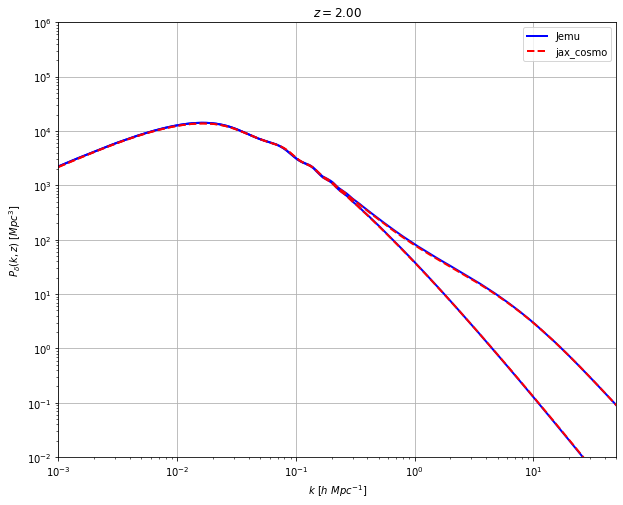

In [15]:

plt.figure(figsize=(10,8))

plt.plot(k_star,pk_linear_interp[zbin,:],lw=2, c="b", label="Jemu")
plt.plot(k_star,pk_lin_jc,lw=2, c="r", ls='--', label="jax_cosmo")
#plt.plot(k_star,pk_lin_ccl,lw=2, ls="--", c="lime", label=r"ccl")
#plt.plot(k_star,pk_class_lin,lw=2, ls=":", c="purple",label="classy")



plt.plot(k_star,pk_nonlin_interp[zbin],lw=2, c="b")#, label=r"$P_{{nl}}$ (Jemu)")
plt.plot(k_star,pk_nonlin_jc,lw=2, c="r", ls='--')#, label=r"$P_{{nl}}$ (jax_cosmo)")
#plt.plot(k_star,pk_nonlin_ccl,lw=2, ls="--",c="lime")#,label=r"$P_{{nl}}$ (ccl)")
#plt.plot(k_star,pk_class_nl,lw=2, ls=":", c="purple")#,label="classy")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z)\ [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_ccl:.2f}$");
plt.xlim([1e-3,5e1])
plt.ylim([1e-2,1e6]);

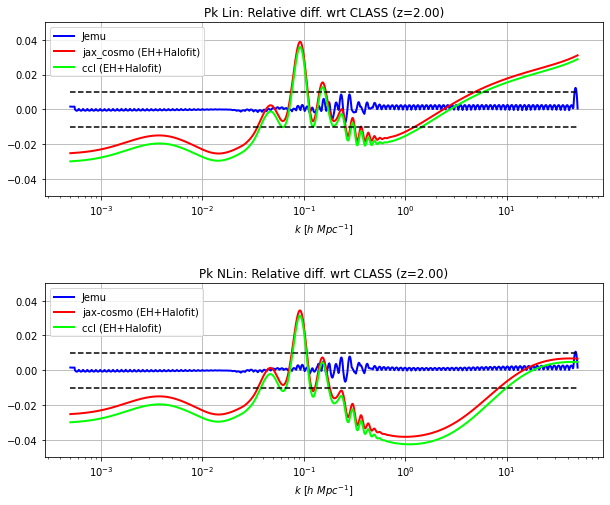

In [25]:
fig, axs= plt.subplots(nrows=2,figsize=(10,8), gridspec_kw={"hspace":0.5})
axs[0].plot(k_star,(pk_linear_interp[zbin,:]-pk_class_lin)/pk_class_lin,lw=2, c="b", label="Jemu")
axs[0].plot(k_star,(pk_lin_jc-pk_class_lin)/pk_class_lin,lw=2, c="r", label="jax_cosmo (EH+Halofit)")
axs[0].plot(k_star,(pk_lin_ccl-pk_class_lin)/pk_class_lin,lw=2, c="lime", label="ccl (EH+Halofit)")
axs[0].legend(loc='upper left')
axs[0].grid()
axs[0].set_xscale("log");

axs[0].set_ylim([-0.05,0.05])
axs[0].plot([k_star.min(),k_star.max()],[-0.01,-0.01],c='k',ls='--')
axs[0].plot([k_star.min(),k_star.max()],[0.01,0.01],c='k',ls='--')
axs[0].set_xlabel(r"$k\ [h\ Mpc^{-1}]$")

axs[0].set_title(f"Pk Lin: Relative diff. wrt CLASS (z={z_ccl:.2f})");


axs[1].plot(k_star,(pk_nonlin_interp[zbin]-pk_class_nl)/pk_class_nl,lw=2, c="b", label="Jemu")#, label=r"$P_{{nl}}$ (Jemu)")
axs[1].plot(k_star,(pk_nonlin_jc-pk_class_nl)/pk_class_nl,lw=2, c="r", label="jax-cosmo (EH+Halofit)")#, label=r"$P_{{nl}}$ (jax_cosmo)")
axs[1].plot(k_star,(pk_nonlin_ccl-pk_class_nl)/pk_class_nl,lw=2,c="lime",  label="ccl (EH+Halofit)")#,label=r"$P_{{nl}}$ (ccl)")
axs[1].grid()
axs[1].legend(loc='upper left')
axs[1].set_xscale("log")
axs[1].set_ylim([-0.05,0.05])
axs[1].plot([k_star.min(),k_star.max()],[-0.01,-0.01],c='k',ls='--')
axs[1].plot([k_star.min(),k_star.max()],[0.01,0.01],c='k',ls='--')
axs[1].set_xlabel(r"$k\ [h\ Mpc^{-1}]$")

axs[1].set_title(f"Pk NLin: Relative diff. wrt CLASS (z={z_ccl:.2f})");


# Jacobians & vectorization

In [16]:
start = timer()
jc_func_nl = lambda p: jc.power.nonlinear_matter_power(p,k_star, 
                                               1./(1+z_ccl))/p.h**3
jac_jc_func_nl = jax.jacfwd(jc_func_nl)(cosmo_jax)
end = timer()
print("end-start (sec)",end - start)

end-start (sec) 100.65988017618656


In [15]:
start = timer()
func_nl = lambda p: emu.linear_pk(p,k_star, z_star=z_ccl)
jac_nonlin_emu = jax.jacfwd(func_nl)(cosmo_jax)
end = timer()
print("end-start (sec)",end - start)

2022-07-04 10:59:15.442790: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[8,5]{1,0} custom-call(f64[8,5]{1,0} %parameter.20278, f64[5,5]{0,1} %constant.327801), custom_call_target="__cublas$gemm", backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"40\",\"rhs_stride\":\"25\"}" failed. Falling back to default algorithm. 
2022-07-04 10:59:15.443272: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.3 = f64[8,1000]{1,0} custom-call(f64[8,5]{1,0}

end-start (sec) 1127.7842464484274


In [16]:
start = timer()
func_nl = lambda p: emu.nonlinear_pk(p,k_star, z_star=z_ccl)
jac_nonlin_emu = jax.jacfwd(func_nl)(cosmo_jax)
end = timer()
print("end-start (sec)",end - start)

2022-07-04 11:09:54.481683: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[8,5]{1,0} custom-call(f64[8,5]{1,0} %parameter.13, f64[5,5]{1,0} %parameter.10), custom_call_target="__cublas$gemm", backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"40\",\"rhs_stride\":\"25\"}" failed. Falling back to default algorithm. 


end-start (sec) 15.904035054147243


### Notice that the emulator has a fixed (Omega_k, w0, wa) values so the gradients are not relevant for these parameters 

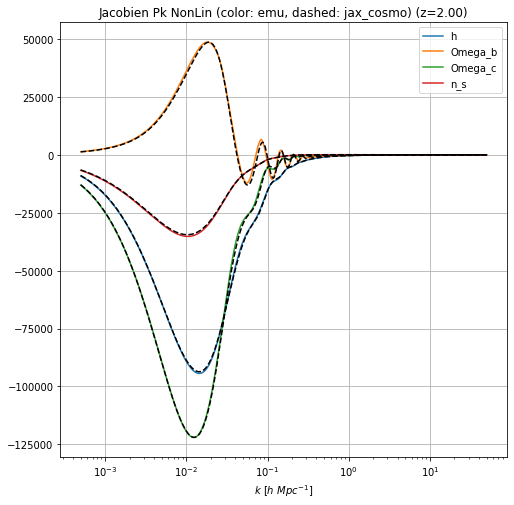

In [18]:
# Omega_c, Omega_b, h, n_s, sigma8, Omega_k, w0, wa, gamma=None
titles=f"Jacobien Pk NonLin (color: emu, dashed: jax_cosmo) (z={z_ccl:.2f})"
lines=["-","--"]
colors=[None,"k"]
fig = plt.figure(figsize=(8,8))
for i,jaco in enumerate([jac_nonlin_emu, jac_jc_func_nl]):
    plt.plot(k_star,jaco.h,label="h",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.Omega_b,label="Omega_b",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.Omega_c,label="Omega_c",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.n_s,label="n_s",c=colors[i],ls=lines[i])
    if i == 0:
        plt.legend();
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")
plt.xscale("log")
plt.title(titles)
plt.grid()

In [19]:
# Omega_c, Omega_b, h, n_s, sigma8, Omega_k, w0, wa, gamma=None
Omega_c_arr = jnp.linspace(cosmo_jax.Omega_c*0.5,cosmo_jax.Omega_c*1.5,10)
axes = jc.Cosmology(Omega_c=0,
                    Omega_b=None,h=None,n_s=None,sigma8=None,Omega_k=None,w0=None,wa=None,gamma=None)

In [20]:
start = timer()
pk_nonlin_Omegac_emu = jax.vmap(func_nl, in_axes=(axes,))(
    jc.Cosmology(
        Omega_c=Omega_c_arr,
        Omega_b=cosmo_jax.Omega_b,
        h=cosmo_jax.h,
        n_s=cosmo_jax.n_s,
        sigma8=cosmo_jax.sigma8,
        Omega_k=cosmo_jax.Omega_k,
        w0=cosmo_jax.w0,
        wa=cosmo_jax.wa,
        gamma=cosmo_jax.gamma))
end = timer()
print("end-start (sec)",end - start)

2022-07-04 10:07:04.253385: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[10,5]{1,0} custom-call(f64[10,5]{1,0} %subtract.3, f64[5,5]{1,0} %parameter.10), custom_call_target="__cublas$gemm", backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"50\",\"rhs_stride\":\"25\"}" failed. Falling back to default algorithm. 
2022-07-04 10:07:04.253913: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.3 = f64[10,1000]{1,0} custom-call(f64[10,5]{1,0} %bi

end-start (sec) 11.336154585704207


In [21]:
start = timer()
pk_nonlin_Omegac_jc = jax.vmap(jc_func_nl, in_axes=(axes,))(
    jc.Cosmology(
        Omega_c=Omega_c_arr,
        Omega_b=cosmo_jax.Omega_b,
        h=cosmo_jax.h,
        n_s=cosmo_jax.n_s,
        sigma8=cosmo_jax.sigma8,
        Omega_k=cosmo_jax.Omega_k,
        w0=cosmo_jax.w0,
        wa=cosmo_jax.wa,
        gamma=cosmo_jax.gamma))
end = timer()
print("end-start (sec)",end - start)

end-start (sec) 63.45124178752303


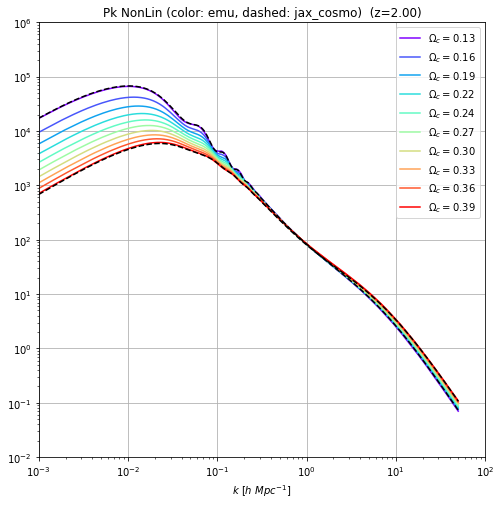

In [22]:
titles=f"Pk NonLin (color: emu, dashed: jax_cosmo)  (z={z_ccl:.2f})"
fig = plt.figure(figsize=(8,8))
for iax,pk_emu in enumerate([pk_nonlin_Omegac_emu, pk_nonlin_Omegac_jc]):
    color = iter(mpl.cm.rainbow(np.linspace(0, 1, pk_emu.shape[0])))
    for i in range(pk_emu.shape[0]):
        if iax==0:
            c = next(color)
            plt.plot(k_star,pk_emu[i,:],c=c,label=fr"$\Omega_c=${Omega_c_arr[i]:.2f}");
        else:
            if i==0 or i==pk_emu.shape[0]-1:
                plt.plot(k_star,pk_emu[i,:],c='k',ls='--')
plt.xscale("log")
plt.yscale("log")
plt.title(titles)
plt.grid()
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])
plt.legend()
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$");